In [15]:
# Lots of imports needed
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, save
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, ColumnDataSource, HoverTool, LogColorMapper
from bokeh.palettes import brewer

In [16]:
# Reading the Data, using a specific sheet name. Starting off by skipping the first 5 rows, because that completely messes up the data.
alb_mbd = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="ALB_MBD", skiprows=5)
pzq = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="PZQ", skiprows=5)
ivm = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="IVM", skiprows=5)
mda = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="COUNTRY_INFO", skiprows=5)
nigeria_lf = pd.read_csv('../Data/Nigeria/data-NG-lf-iu-2017-undefined-2017.csv')
nigeria_lf.loc[nigeria_lf.ADMIN1_NAME == 'Fct, Abuja', 'ADMIN1_NAME'] = 'Federal Capital Territory'
nigeria_lf.loc[nigeria_lf.ADMIN1_NAME == 'Nassarawa', 'ADMIN1_NAME'] = 'Nasarawa'

In [17]:
## printing the top two rows, as these are the unformated columns. I used this to figure out which columns I needed for the data.
#print(data.loc[0])
#print(data.loc[1])
#nigeria_lf.head()
mda.head()

,Country administrative structure,Unnamed: 1,Unnamed: 2,Population,Unnamed: 4,Unnamed: 5,Unnamed: 6,Endemicity,Unnamed: 8,Unnamed: 9,...,Number of treatment\nrounds planned for the year,Unnamed: 17,Unnamed: 18,Unnamed: 19,Epidemiological surveys\nplanned for the year,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Country,Province/State,District,Total,PreSAC,SAC,Adults,LF,Oncho,STH,...,LF,Oncho,STH,SCH,LF,Oncho,STH,SCH,IU_ID,IU_NAME
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nigeria,Abia,Aba North,144559,28912,40477,75171,1,1,2,...,1,2,1,0,NaN,NaN,NaN,NaN,36337,Aba North
3,Nigeria,Abia,Aba South,570034,114007,159609,296418,1,1,2,...,1,2,1,0,NaN,NaN,NaN,NaN,36338,Aba South
4,Nigeria,Abia,Arochukwu,228908,45782,64094,119032,1,1,3,...,1,2,2,0,NaN,NaN,NaN,NaN,36339,Arochukwu


In [47]:
lf_prev = mda.iloc[2:, 7]
oncho_prev = mda.iloc[2:, 8]
sth_prev = mda.iloc[2:, 9]
schisto_prev = mda.iloc[2:, 10]

lf_mda = mda.iloc[2:, 16]
oncho_mda = mda.iloc[2:, 17]
sth_mda = mda.iloc[2:, 18]
schisto_mda = mda.iloc[2:, 19]

In [53]:
schisto_prev.value_counts()

1    282
2    271
0    187
4     24
3     10
Name: Unnamed: 10, dtype: int64

In [22]:
#IVM LF & Oncho
ivm_total_treatment_lf = ivm.iloc[2:, 6]

# the total treatment for ivm for oncho does not include the values from in the district
oncho_ivm_total_treatment = ivm.iloc[2:, 9]
lf_ivm_total_treatment = ivm.iloc[2:, 6]
#ivm_total_treatment = ivm_total_treatment_lf + ivm_total_treatment_oncho
lf_ivm_procured = ivm.iloc[2:, 10] + ivm.iloc[2:, 12]
oncho_ivm_procured = ivm.iloc[2:, 11]
oncho_ivm_procured[(oncho_ivm_procured == 0)] = ivm.iloc[2:, 12][(oncho_ivm_procured == 0)]

In [23]:
#Schistosomaisis
pzq_dist_names = pzq.iloc[2:, 2]
pzq_total_treatment = pzq.iloc[2:, 5]
pzq_tab_procured = pzq.iloc[2:, [16, 17]]
schisto_pzq_total_procured = pzq_tab_procured.iloc[:, 0]# + pzq_tab_procured.iloc[:, 1]

In [24]:
# Here I selecte the different colummns I  need and store them as seperate Series. The rows start at level 2
# The columns for the first two variables have names, but the rest I find by indexing.
state_names = alb_mbd.loc[2:, "Unnamed: 1"]
district_names = alb_mbd.loc[2:, "Unnamed: 2"]
alb_mbd_total_treatment = alb_mbd.loc[2:, "Population requiring treatment with ALB/MBD"]
total_target_mbd = alb_mbd.iloc[2:, 19]
total_target_alb = alb_mbd_total_treatment - total_target_mbd
lf_alb_tab_bottle = alb_mbd.iloc[2:, 21:23]
sth_alb_tab_bottle = alb_mbd.iloc[2:, 24:26]
sth_mbd_tab_bottle = alb_mbd.iloc[2:, 27:29]

In [56]:
# combining the different Series into one dataframe
selectedData = pd.DataFrame({'state_names':state_names, 'district_names':district_names, 'total_treatment_mbd_alb':alb_mbd_total_treatment, 
                             'total_target_alb':total_target_alb, 'total_target_mbd':total_target_mbd, 
                             'lf_alb_total_procured':lf_alb_tab_bottle.iloc[:,0], 'sth_mbd_total_procured':sth_mbd_tab_bottle.iloc[:,0], 
                            'schisto_pzq_total_treatment':pzq_total_treatment, 'schisto_pzq_total_procured':schisto_pzq_total_procured, 
                             'lf_ivm_total_treatment':lf_ivm_total_treatment, 'lf_ivm_total_procured':lf_ivm_procured, 
                             'oncho_ivm_total_treatment':oncho_ivm_total_treatment, 'oncho_ivm_total_procured':oncho_ivm_procured,
                            'lf_prev':lf_prev, 'oncho_prev':oncho_prev, 'sth_prev':sth_prev, 'schisto_prev':schisto_prev,
                            'lf_mda':lf_mda, 'oncho_mda':oncho_mda, 'sth_mda':sth_mda, 'schisto_mda':schisto_mda})

# the data is of type string, so here I am just changing everything but the district names to numerics
for col in selectedData.columns:
    if (col != 'district_names') & (col != 'state_names'):
        selectedData[col] = pd.to_numeric(selectedData[col])

# grouping the data by district names and using a mean to aggregate districts that may have multiple rows
# this is probably not the right way to do it, but it was a quick solution
selectedData = selectedData.groupby(['state_names', 'district_names']).mean().reset_index()

stateData = selectedData.groupby('state_names').sum().reset_index()
stateData.loc[stateData.state_names=='FCT', 'state_names'] = 'Federal Capital Territory'
stateData.loc[stateData.state_names=='Nassarawa', 'state_names'] = 'Nasarawa'
stateData.loc[stateData.total_target_alb <0, 'total_target_alb'] = 0
stateData.sample(5)
#selectedData

,state_names,total_treatment_mbd_alb,total_target_alb,total_target_mbd,lf_alb_total_procured,sth_mbd_total_procured,schisto_pzq_total_treatment,schisto_pzq_total_procured,lf_ivm_total_treatment,lf_ivm_total_procured,oncho_ivm_total_treatment,oncho_ivm_total_procured,lf_prev,oncho_prev,sth_prev,schisto_prev,lf_mda,oncho_mda,sth_mda,schisto_mda
23,Kwara,637770,0,1073543,1403986,462938,520153.09,546347.50,1403986,3.931161e+06,2.224374e+06,6.228247e+06,11,16,29,21,11,16,13,6
33,Sokoto,994410,787569,206841,3376672,0,1062223.78,1235176.25,3376672,9.454682e+06,1.961340e+05,5.491752e+05,20,1,28,39,20,1,5,15
10,Ebonyi,584623,0,1237777,1804517,617623,459699.46,482802.50,852442,3.120777e+06,1.059526e+06,2.966672e+06,9,11,27,19,9,11,14,7
32,Rivers,1394758,0,3333820,3149559,1619214,0.00,0.00,2232095,6.249866e+06,0.000000e+00,0.000000e+00,13,0,53,0,13,0,30,0
29,Osun,920854,0,1961396,3318199,707220,496795.31,229112.50,2996086,8.930588e+06,1.528309e+06,4.279266e+06,27,28,70,31,27,28,40,4


In [11]:
#lf_big_data = pd.read_csv('../Data/Nigeria/data-NG-lf-iu-2017-undefined-2017.csv')
#lf_big_data = lf_big_data[['ADMIN1_NAME', 'IU_Name', 'PopReq', 'PopTreat']]

In [32]:
pop_data = pd.read_csv('../Data/Nigeria/nigeria_state_population.csv')
pop_data.loc[pop_data.state=='Abuja', 'state'] = 'Federal Capital Territory'
pop_data.loc[pop_data.state=='Nassarawa', 'state'] = 'Nasarawa'
#pop_data['lf_prevalence'] = pop_data['population'] * 0.086559804
#pop_data['lf_yld'] = pop_data['lf_prevalence'] * 0.11
pop_data['lf_yld'] = pop_data['population'] / 252.7704506

#p0p_data['oncho_prevalence'] = pop_data['population'] * 0.015659449
pop_data['oncho_yld'] = pop_data['population'] / 108.1873017

#pop_data['schisto_prevalence'] = pop_data['population'] * 0.132141449
pop_data['schisto_yld'] = pop_data['population'] / 96.53187941

pop_data.head()

,state,population,lf_yld,oncho_yld,schisto_yld
0,Kano,13076892,51734.259163,120872.706820,135467.081755
1,Lagos,12550598,49652.156612,116008.050878,130015.059032
2,Kaduna,8252366,32647.668984,76278.508386,85488.504424
3,Oyo,7840864,31019.701794,72474.901183,81225.643258
4,Katsina,7831319,30981.940260,72386.674563,81126.764007


In [34]:
full_state_data = stateData.merge(pop_data, left_on='state_names', right_on='state')
#merged_state_data = stateData.merge(pop_data, left_on='state_names', right_on='state')
#full_state_data = merged_state_data.merge(nigeria_lf, left_on='district_names', right_on='IU_Name')

# summing up all the requested columns and dividing them by the target population
full_state_data['alb_ratio'] = full_state_data['lf_alb_total_procured'] / full_state_data['total_target_alb']
full_state_data['mbd_ratio'] = full_state_data['sth_mbd_total_procured'] / full_state_data['total_target_mbd']
full_state_data['pzq_ratio'] = full_state_data['schisto_pzq_total_procured'] / full_state_data['schisto_pzq_total_treatment']
full_state_data['oncho_ivm_ratio'] = full_state_data['oncho_ivm_total_procured'] / full_state_data['oncho_ivm_total_treatment']
full_state_data['lf_ivm_ratio'] = full_state_data['lf_ivm_total_procured'] / full_state_data['lf_ivm_total_treatment']

full_state_data.loc[(pd.isna(full_state_data.pzq_ratio)), 'pzq_ratio'] = 0
full_state_data.loc[(pd.isna(full_state_data.alb_ratio)), 'alb_ratio'] = 0
full_state_data.loc[full_state_data.alb_ratio == float("inf"), 'alb_ratio'] = 0
full_state_data.loc[(pd.isna(full_state_data.mbd_ratio)), 'mbd_ratio'] = 0
full_state_data.loc[(pd.isna(full_state_data.oncho_ivm_ratio)), 'oncho_ivm_ratio'] = 0
full_state_data.loc[(pd.isna(full_state_data.lf_ivm_ratio)), 'lf_ivm_ratio'] = 0
full_state_data.sample(5)
full_state_data.to_csv('state_nigeria_data_3.csv')

In [57]:
full_state_data.head()

,state_names,total_treatment_mbd_alb,total_target_alb,total_target_mbd,lf_alb_total_procured,sth_mbd_total_procured,schisto_pzq_total_treatment,schisto_pzq_total_procured,lf_ivm_total_treatment,lf_ivm_total_procured,...,state,population,lf_yld,oncho_yld,schisto_yld,alb_ratio,mbd_ratio,pzq_ratio,oncho_ivm_ratio,lf_ivm_ratio
0,Abia,762282,0,990432,3049131,167548,95517.18,0.00,3049131,8537566.8,...,Abia,3727347,14745.976008,34452.721728,38612.601586,0.000000,0.169167,0.000000,2.8,2.8
1,Adamawa,852147,792834,59313,2868274,0,809107.55,959070.00,2868274,8031167.2,...,Adamawa,4248436,16807.486753,39269.266663,44010.704298,3.617748,0.000000,1.185343,2.8,2.8
2,Akwa Ibom,1054449,0,3850694,1345455,2107742,6620.79,0.00,949701,2659162.8,...,Akwa Ibom,5482177,21688.361859,50673.017201,56791.362952,0.000000,0.547367,0.000000,2.8,2.8
3,Anambra,1124876,511086,613790,4499495,0,266114.97,0.00,4499495,12598586.0,...,Anambra,5527809,21868.889290,51094.804225,57264.077254,8.803792,0.000000,0.000000,2.8,2.8
4,Bauchi,1257843,1257843,0,2871021,0,1054755.27,1342308.75,2871021,8038858.8,...,Bauchi,6537314,25862.651210,60425.890075,67721.814182,2.282496,0.000000,1.272626,2.8,2.8


In [44]:
# loading in geojson
shapefile = '../Data/Nigeria/Nigeria_Shape/AFRO_IUs_201812.shp'
gdf = gpd.read_file(shapefile)
nigeria = gdf[gdf.ADMIN0 == 'Nigeria'].copy()
nigeria = nigeria.loc[:, ['CONTINENT', 'REGION', 'ADMIN0', 'ADMIN1', 'IUs_NAME', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'geometry']]

In [45]:
final_data = nigeria.merge(full_state_data, left_on='ADMIN1', right_on='state_names')
# merging the two data sets
#merged = nigeria.merge(selectedData, left_on='IUs_NAME', right_on='district_names')
#merged = nigeria.merge(stateData, left_on='ADMIN1', right_on='state_names')

#merged_pop = merged.merge(pop_data, left_on='ADMIN1', right_on='state')
#final_merged = merged_pop.merge(nigeria_lf, left_on='ADMIN1', right_on='ADMIN1_NAME')

In [ ]:
#final_merged = final_merged.loc[:, ['CONTINENT', 'REGION', 'ADMIN0', 'ADMIN1', 'IUs_NAME', 'Shape_Leng',
#       'Shape_Le_1', 'Shape_Area', 'geometry', 'state_names',
#       'total_treatment_mbd_alb', 'total_target_alb', 'total_target_mbd',
#       'lf_alb_total_procured', 'sth_mbd_total_procured',
#       'schisto_pzq_total_treatment', 'schisto_pzq_total_procured',
#       'lf_ivm_total_treatment', 'lf_ivm_total_procured',
#       'oncho_ivm_total_treatment', 'oncho_ivm_total_procured', 'alb_ratio',
#       'mbd_ratio', 'pzq_ratio', 'oncho_ivm_ratio', 'lf_ivm_ratio', 'population', 'lf_yld', 'oncho_yld', 'schisto_yld', 'Endemicity', 'MDA_start_APOC',
#       'LF_MDA_duration', 'start_year', 'end_year', 'Period', 'PopReq',
#       'PopTreat', 'Cov', 'MDA', 'EffMDA', 'MDA_n', 'EffMDA_n', 'MDA_left']]

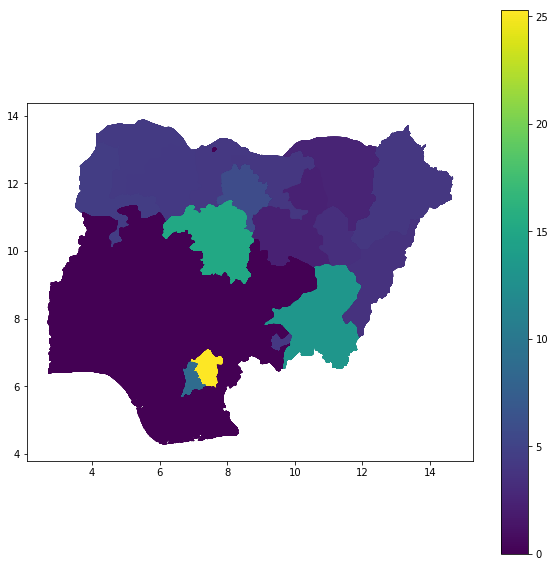

In [46]:
# creating a plot
# any white space is probably a null value, meaning either no data, or something is wrong the data cleaning I did
final_data.plot(column='alb_ratio', legend=True, figsize=(10,10))

In [ ]:
final_data.plot(column=['lf_yld', 'alb_ratio'], legend=True, figsize=(10,10))

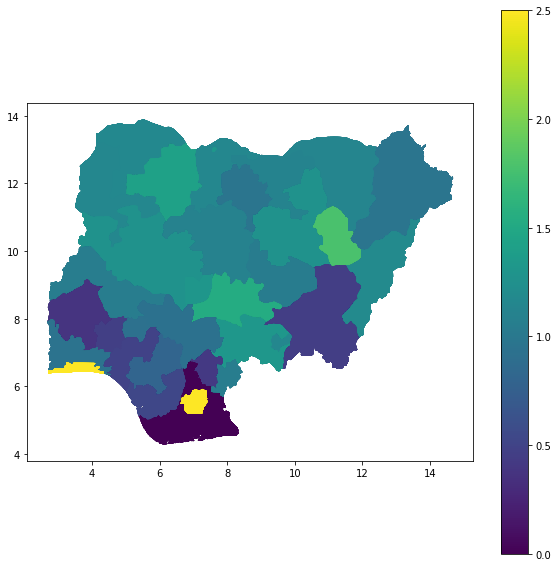

In [47]:
final_data.plot(column='pzq_ratio', legend=True, figsize=(10,10))

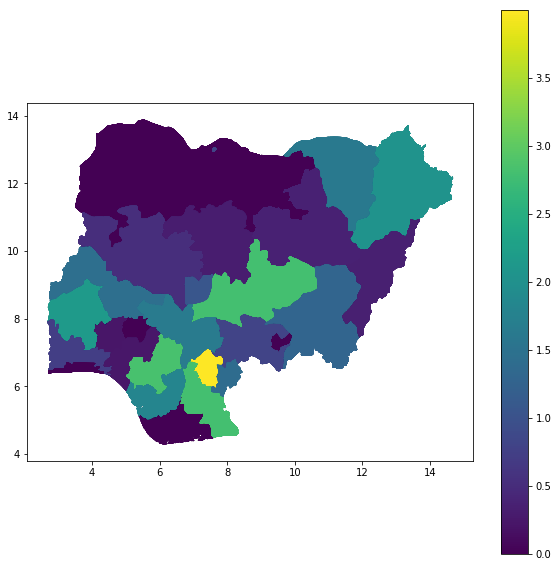

In [50]:
final_data.plot(column='oncho_ivm_ratio', legend=True, figsize=(10,10))